# Object Localization

## Global Activation Pooling

### Theory

- Learn the relevance(weights) of the pooled(average) feature maps
- Use these weights to go map it back to the image

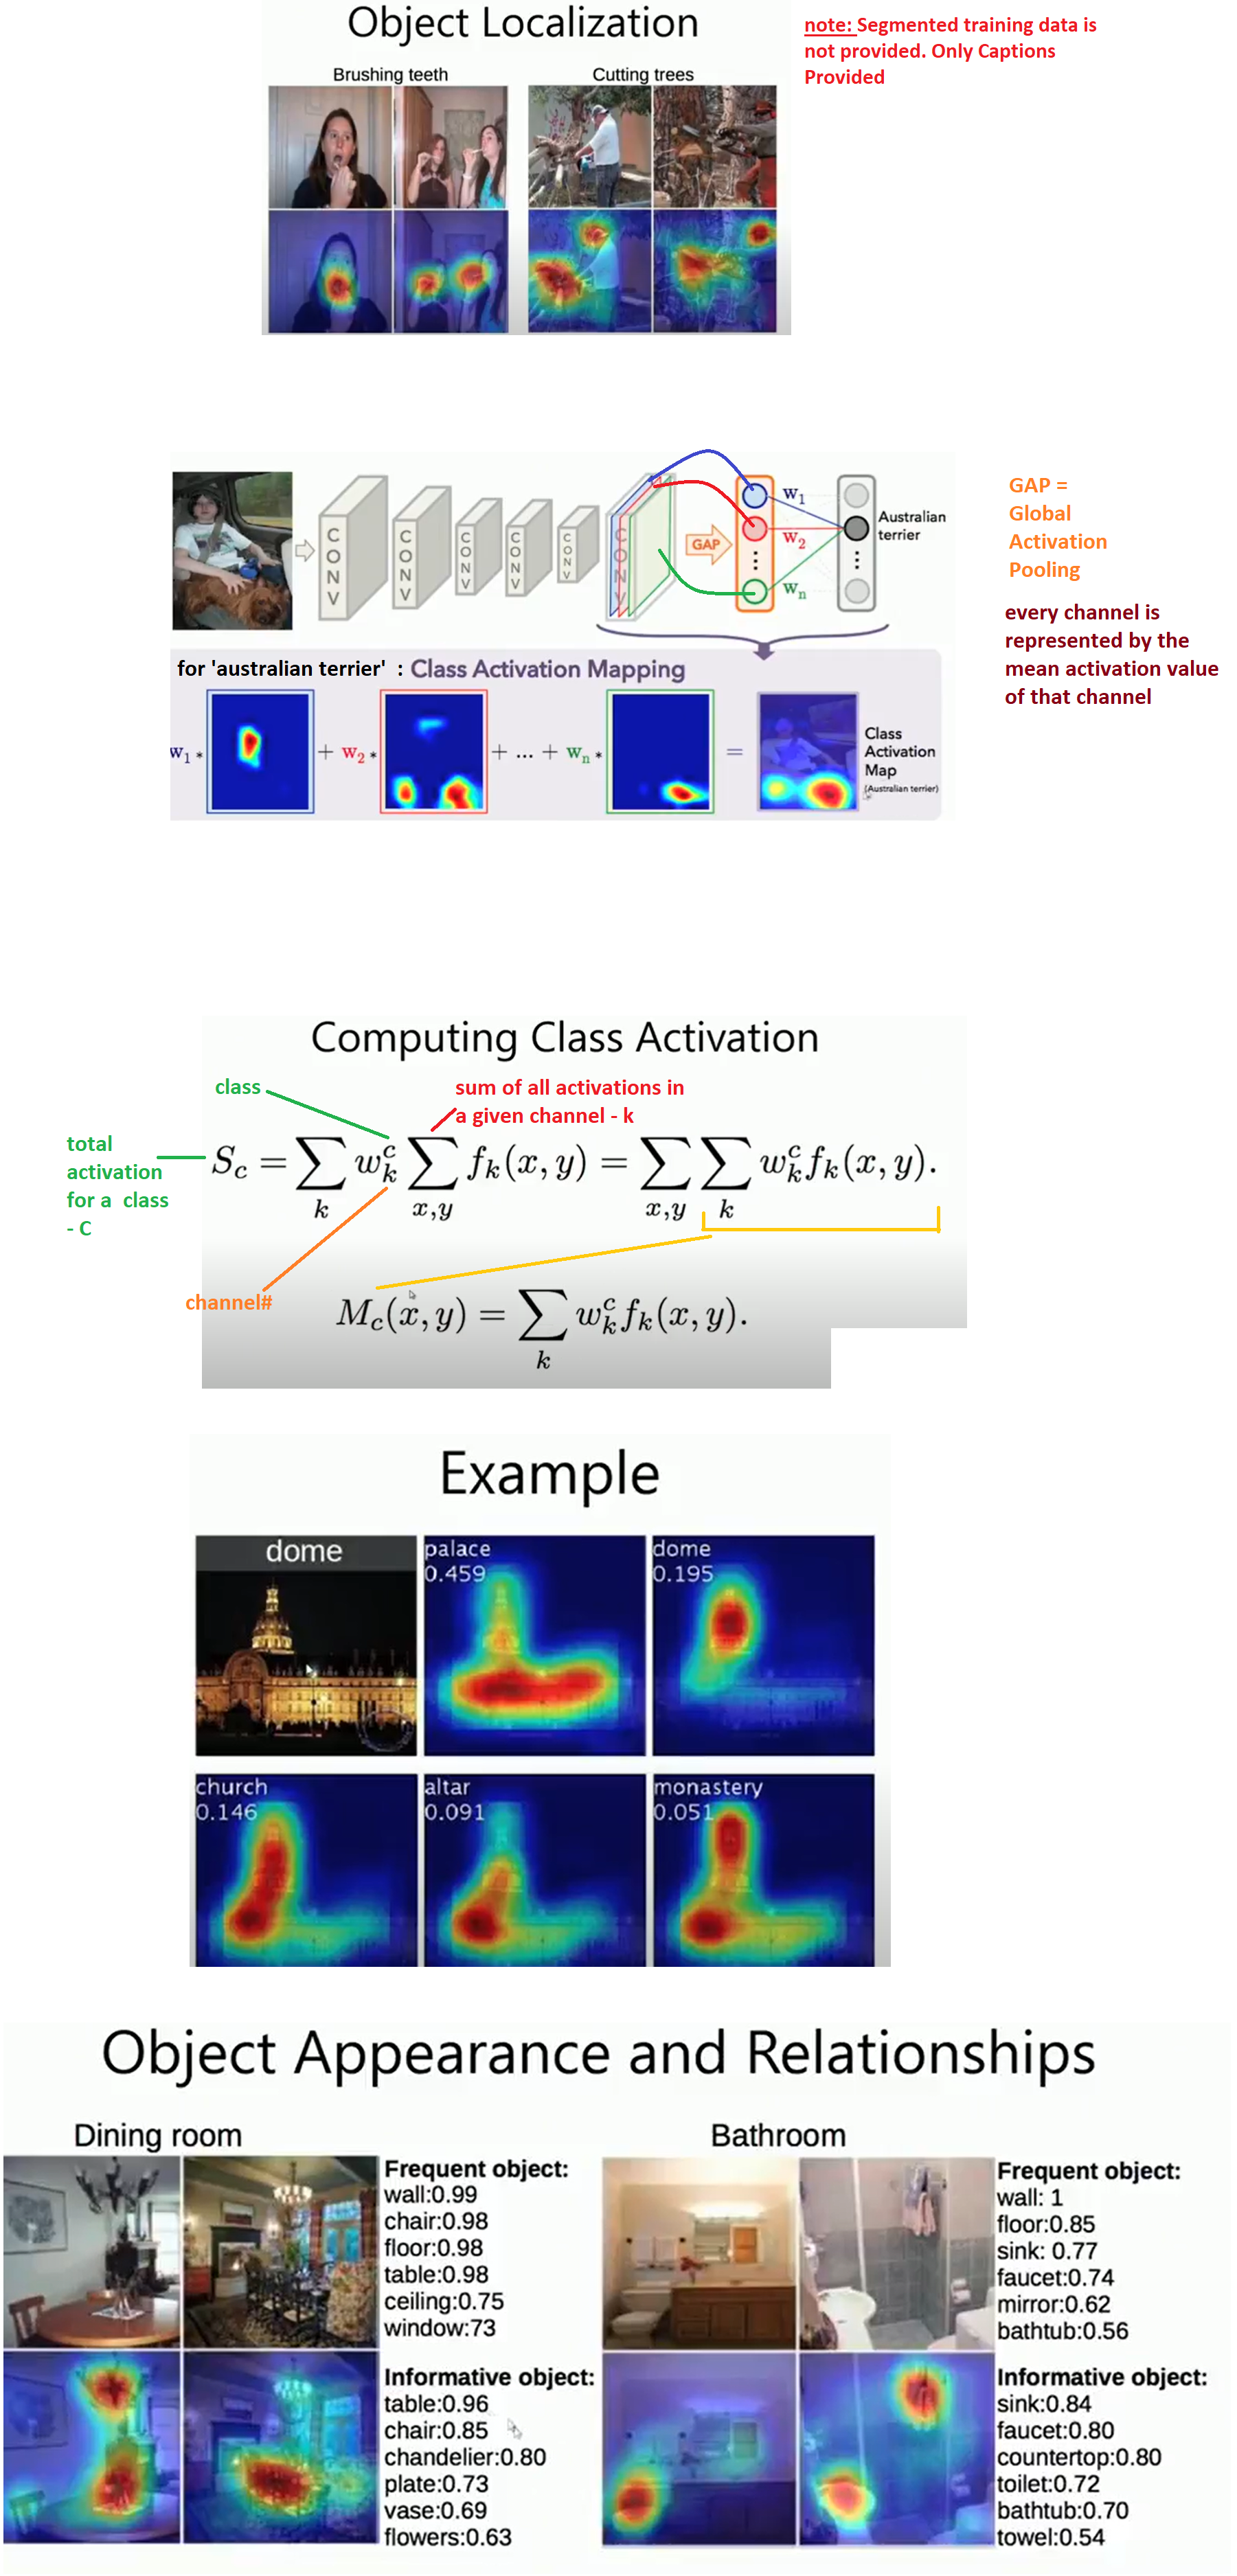

### Code - Global Activation pooling - Lukemia Image

#### Import

In [1]:
%matplotlib inline
import os
import time
import copy
import tqdm
import torch
import random
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.5.0


#### Load Data

In [4]:
Datapath = 'IDB Dataset/ALL_IDB2/img/'
listing = os.listdir(Datapath) 
random.shuffle(listing)

In [33]:
# ALL_IDB2 dataset has 260 images in total
TrainImages = torch.FloatTensor(200,3,224,224)
TrainLabels = torch.LongTensor(200)
TestImages = torch.FloatTensor(60,3,224,224)
TestLabels = torch.LongTensor(60)

In [34]:
# First 200 images are used for training and the remaining 60 for testing
img_no = 0
for file in listing:
    im=Image.open(Datapath + file)
    im = im.resize((224,224))
    im = np.array(im)   
    if img_no < 200:
        TrainImages[img_no] = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
                       ##(1,3,224,224)
        TrainLabels[img_no] = int(listing[img_no][6:7])
    else:
        TestImages[img_no - 200] = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
        TestLabels[img_no - 200] = int(listing[img_no][6:7])
    img_no = img_no + 1

In [35]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([200, 3, 224, 224])
torch.Size([200])
torch.Size([60, 3, 224, 224])
torch.Size([60])


In [36]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
# use_gpu = False # Uncomment in case of GPU memory error
if use_gpu:
    print('GPU is available!')
    device = "cuda"
    pinMem = True
else:
    print('GPU is not available!')
    device = "cpu"
    pinMem = False

GPU is available!


In [56]:
# Creating pytorch dataset
trainDataset = TensorDataset(TrainImages, TrainLabels)
testDataset = TensorDataset(TestImages, TestLabels)
# Creating dataloader
BatchSize = 10
trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=pinMem)
testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=False,num_workers=4, pin_memory=pinMem)

#### Initialize the network

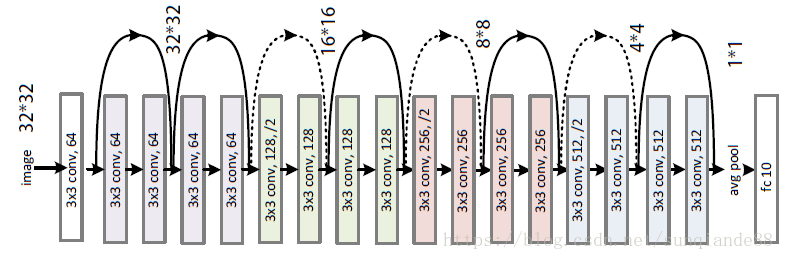

In [53]:
# ResNet18
net = models.resnet18(pretrained=True)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
# ResNet18
net = models.resnet18(pretrained=True)

num_ftrs = net.fc.in_features    #512
net.fc = nn.Linear(num_ftrs, 2)  #512 - 2 (since cancer/non-cancerous output)
print(net)
net = net.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 2.00 GiB total capacity; 61.53 MiB already allocated; 0 bytes free; 84.00 MiB reserved in total by PyTorch)

#### Define loss function and optimizer

In [58]:
criterion = nn.NLLLoss() # Negative Log-Likelihood
optimizer = optim.SGD(net.parameters(), lr=1e-3 , momentum=0.9) 
# Stochastic gradient descent

#### Train the network

In [59]:
device = 'cuda'

In [60]:
iterations = 15
trainLoss = []
trainAcc = []
testLoss = []
testAcc = []
start = time.time()

for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0   
    runningCorr = 0
    net.train() # For training
    for data in tqdm.tqdm_notebook(trainLoader):
        inputs,labels = data
        inputs, labels = inputs.to(device), labels.long().to(device)          
       
        inputs = inputs/255.0  #(0-1) normalization
        # Feed-forward input data through the network
        outputs = net(inputs)
        # Compute loss/error
        loss = criterion(F.log_softmax(outputs,dim=1), labels) 
        
        _, predicted = torch.max(outputs.data, 1)
        # Initialize gradients to zero
        optimizer.zero_grad()                  
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.item()  
        # Accumuate correct predictions per batch
        runningCorr += (predicted == labels.data).sum()
    avgTrainLoss = runningLoss/(200.0/BatchSize)
    avgTrainAcc = 100*float(runningCorr)/200.0
    trainLoss.append(avgTrainLoss)
    trainAcc.append(avgTrainAcc)
    
    # Evaluating performance on test set for each epoch
    net.eval() # For testing
    test_runningCorr = 0
    test_runningLoss = 0
    with torch.no_grad():
        for data in testLoader:
            inputs,labels = data
            inputs, labels = inputs.to(device), labels.long().to(device)  
            inputs = inputs/255
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)    
             # Compute loss/error
            loss = criterion(F.log_softmax(outputs,dim=1), labels)      
            # Accumulate loss per batch
            test_runningLoss += loss.item()  
            # Accumuate correct predictions per batch
            test_runningCorr += (predicted == labels.data).sum()
    avgTestLoss = test_runningLoss/(60.0/BatchSize)
    avgTestAcc = 100*float(test_runningCorr)/60.0
    testAcc.append(avgTestAcc)
    testLoss.append(avgTestLoss)
        
    # Plotting Loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r--',label='train')        
    plt.plot(range(epoch+1),testLoss,'g--',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')    
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),trainAcc,'r-',label='train') 
    plt.plot(range(epoch+1),testAcc,'g-',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')    
    
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Training Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTrainAcc,epochEnd//60,epochEnd%60))
    print('At Iteration: {:.0f} /{:.0f}  ;  Testing Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTestLoss,avgTestAcc,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

C:\Users\Ashwin\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 2.00 GiB total capacity; 67.28 MiB already allocated; 0 bytes free; 84.00 MiB reserved in total by PyTorch)

In [63]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [64]:
# Extracting the convolutional layers of the network
conv_net = nn.Sequential(*list(net.children())[:-2])
print(conv_net)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [46]:
# Copying weights of the final layer for obtaining the segmented output
weights = copy.deepcopy(net.fc.weight.data)
if use_gpu:
    weights = weights.cpu()
weights = weights.numpy()
print(weights.shape)

(2, 512)


In [ ]:
# Loading one sample image for testing
testPath = 'IDB Dataset/ALL_IDB1/im/'
testImages = os.listdir(testPath)
img1 = plt.imread(testPath+testImages[0])
testInput = torch.from_numpy(img1).transpose(0,2).transpose(1,2).unsqueeze(0).float().to(device)

..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


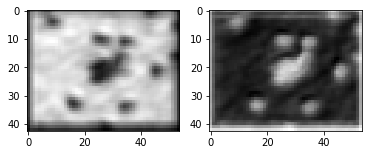

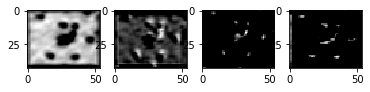

In [50]:
# Feed-forward
out = conv_net(testInput)  

# Visualization
if use_gpu:
    out_np = out.squeeze(0).data.cpu().numpy()
else:
    out_np = out.squeeze(0).data.numpy()

mask1 = np.ones(out_np.shape)
## out_np.shape = (512, 43, 54)  ##512 feature maps of size = (43,54)


## weights.shape = (2, 512)  ##weights of final layer

for n1 in range(512):  #512 feature maps
    mask1[n1] = weights[0,n1]*mask1[n1]

##weighted summation of all the channel outputs
outImg1 = np.sum(np.multiply(mask1,out_np),axis=0)

# Averaged activation map
plt.figure()
plt.subplot(121)
plt.imshow(np.sum(out_np,axis=0)/512,cmap='gray')
# Weighted-sum activation map
plt.subplot(122)
plt.imshow(outImg1,cmap='gray')

# Activation maps chosen at random
plt.figure()
randIdx = np.random.randint(0,511,4)
plt.subplot(141)
plt.imshow(out_np[randIdx[0]],cmap='gray')
plt.subplot(142)
plt.imshow(out_np[randIdx[1]],cmap='gray')
plt.subplot(143)
plt.imshow(out_np[randIdx[2]],cmap='gray')
plt.subplot(144)
plt.imshow(out_np[randIdx[3]],cmap='gray')

In [71]:
import skimage.transform

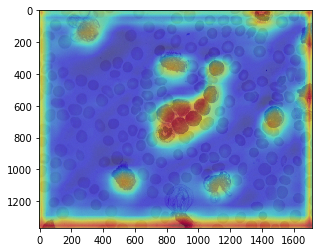

In [84]:
plt.imshow(img1)
plt.imshow(skimage.transform.resize(outImg1, (img1.shape[0],img1.shape[1])), alpha=0.5, cmap='jet')

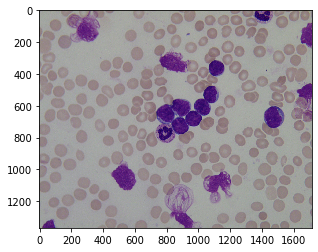

In [68]:
plt.imshow(img1)

## Region Proposal Networks

rCNN - Region Based Convolutional Neural Networks <br>
Faster rCC Model - Better Model

- Classify multiple classes
- Bounding Boxes

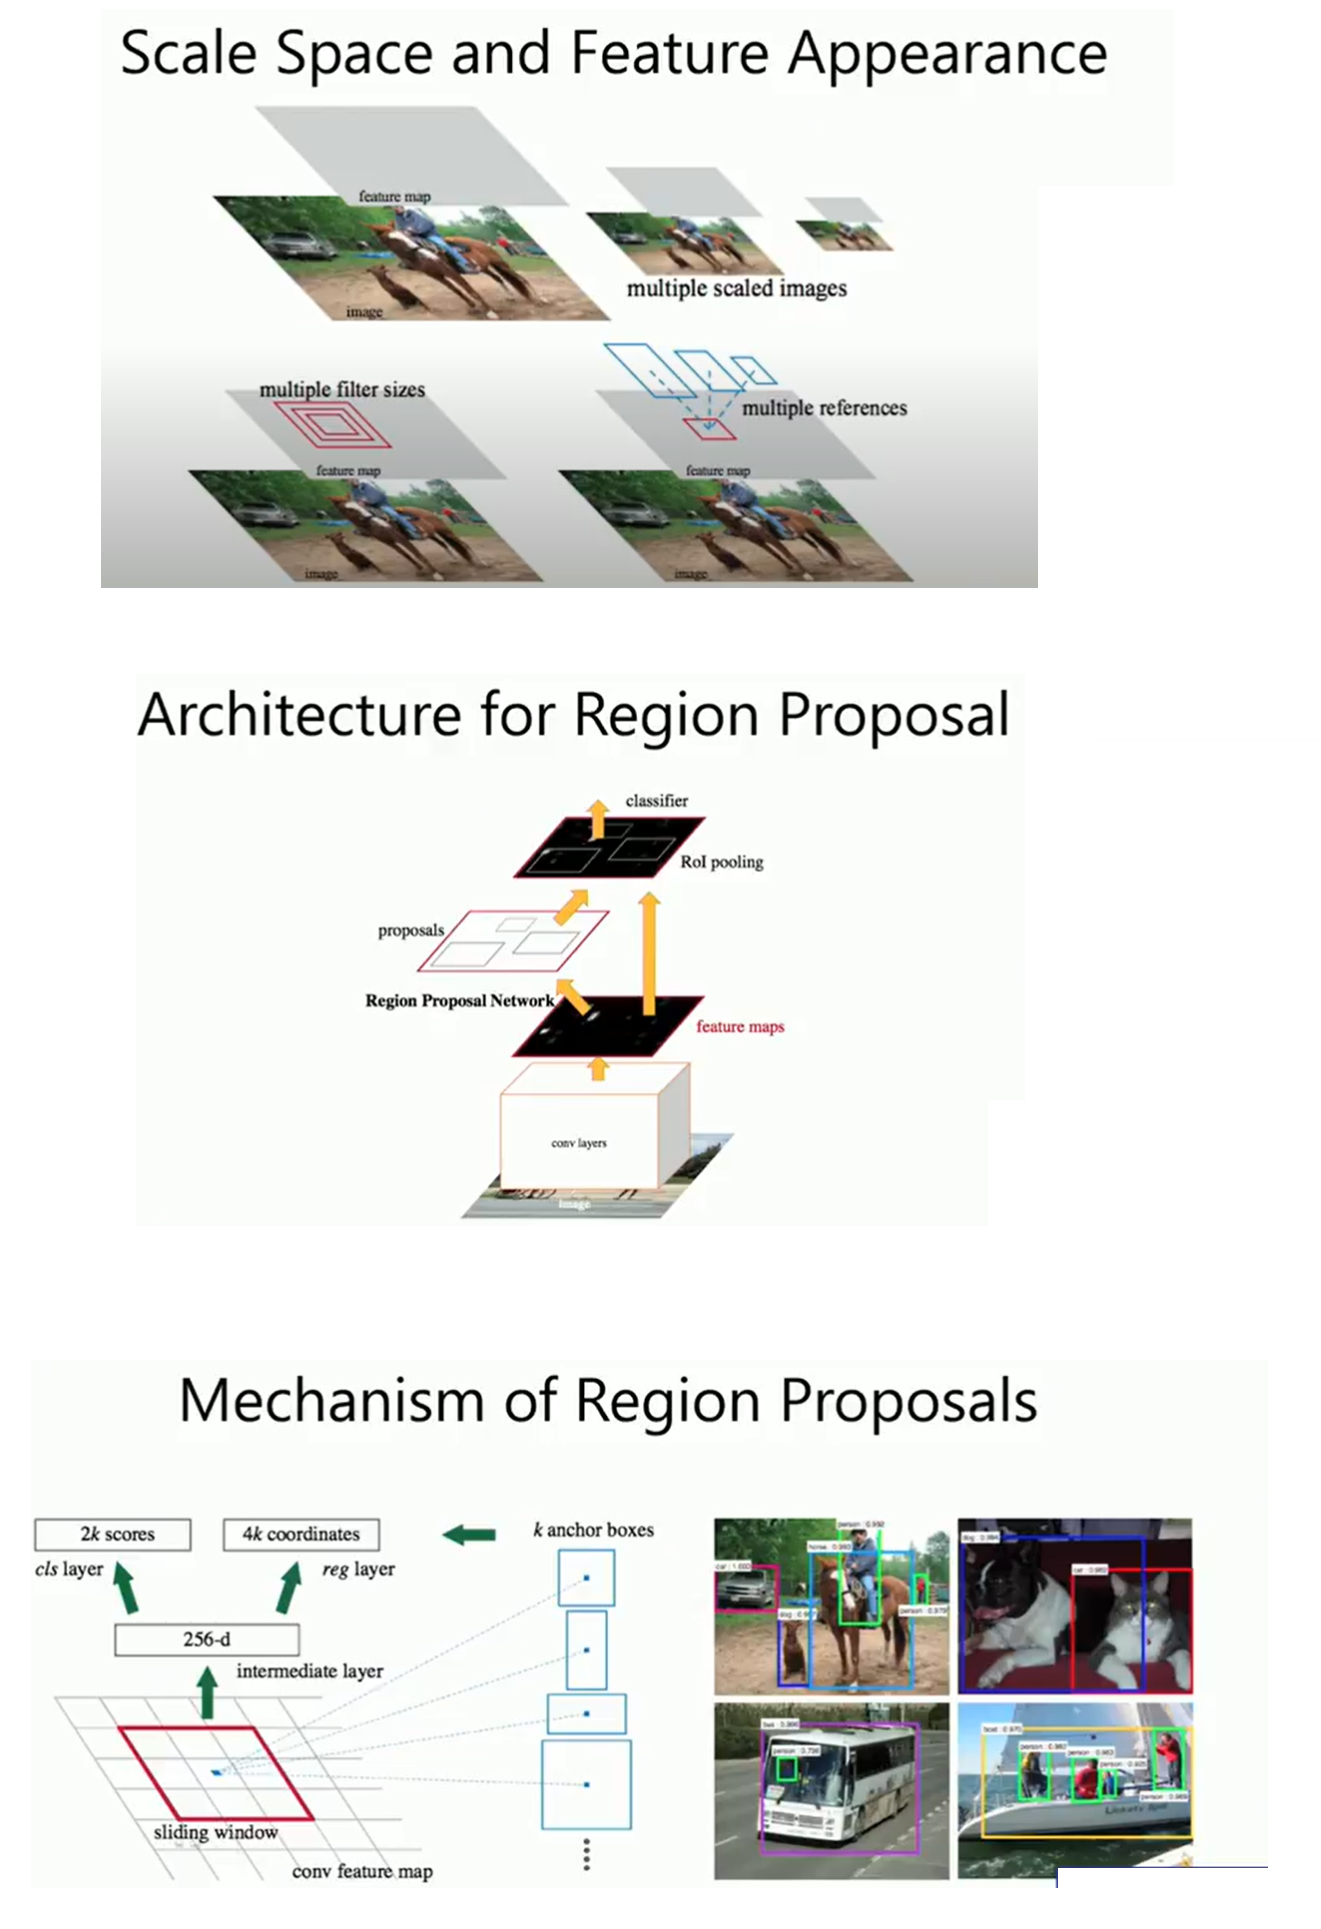